# 4. 2-D Anisotropic Diffusion

In this tutorial, we consider the following anisotropic diffusion problem

$$
	a(v, u) = \int_{\Omega}  \frac{\kappa_{\parallel}}{\|\mathbf{B}\|^2} (\textbf{B} \cdot \nabla v) (\textbf{B} \cdot \nabla u) + \kappa_{I} \nabla v \cdot \nabla u d\Omega, \quad \forall u,v \in \mathcal{V}_h
$$

where $\textbf{B}$ denotes the magnetic field, $\Omega$ is our 2D computational domain and $\mathcal{V}_h \subset H^1(\Omega)$. 
We are interested in highly anisotropic configurations with $\displaystyle \frac{\kappa_{\parallel}}{\kappa_{I}} \simeq 10^6 \gg 1$.

In [1]:
from numpy import linspace, zeros, meshgrid, pi

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import Math

from sympy.core.containers import Tuple
from sympy import symbols
from sympy import Symbol
from sympy import Lambda
from sympy import IndexedBase
from sympy import Function

from gelato.glt import glt_symbol
from gelato.glt import glt_lambdify
from gelato.glt import glt_approximate_eigenvalues
from gelato.calculus   import (Dot, Cross, Grad, Curl, Rot, Div)
from gelato.calculus   import (dx, dy)
from gelato.calculus   import Constant
from gelato.fem.assembly import assemble_matrix
from gelato.fem.utils    import compile_kernel
from gelato.fem.utils    import compile_symbol

from spl.fem.splines import SplineSpace
from spl.fem.tensor  import TensorSpace

In [2]:
x,y = symbols('x y')

u = Symbol('u')
v = Symbol('v')

k_par = Constant('k_par')
k_perp = Constant('k_perp')

b1 = Constant('b1')
b2 = Constant('b2')
b = Tuple(b1, b2)

a = Lambda((x,y,v,u), k_perp * Dot(Grad(v), Grad(u)) + k_par * Dot(b, Grad(v)) * Dot(b, Grad(u)))


In [4]:
# ...  create a finite element space
p1  = 3 ; p2  = 3
ne1 = 32 ; ne2 = 32

grid_1 = linspace(0., 1., ne1+1)
grid_2 = linspace(0., 1., ne2+1)

V1 = SplineSpace(p1, grid=grid_1)
V2 = SplineSpace(p2, grid=grid_2)

V = TensorSpace(V1, V2)
# ...

In [5]:
d_constants = {'b2': 1., 'k_perp': 1.}
d_types = {'b1': 'double', 'k_par': 'double'}

In [6]:
kernel_a = compile_kernel('kernel_a', a, V,
                          d_constants=d_constants,
                          d_args=d_types,
                          backend='fortran')

In [7]:
d_args = {'b1': 1.165939762441386085001227002067, 
          'k_par': 1.e5}

In [8]:
M = assemble_matrix(V, kernel_a, args=d_args).tocsr()

In [9]:
# import eigenvalue solver
from scipy.linalg import eig

M = M.todense()
w, v = eig(M)
wr = w.real
wr.sort()

In [10]:
symbol_a = compile_symbol('symbol_a', a, V,
                          d_constants=d_constants,
                          d_args=d_types,
                          backend='fortran')

In [11]:
# ... example of symbol evaluation
[n1,n2] = [W.nbasis for W in V.spaces]

t1 = linspace(-pi,pi, n1)
t2 = linspace(-pi,pi, n2)
x1 = linspace(0.,1., n1)
x2 = linspace(0.,1., n2)
e = zeros((n1, n2), order='F')
symbol_a(x1,x2,t1,t2, e, d_args['k_par'], d_args['b1'])
t = e.ravel()
t.sort()
# ...

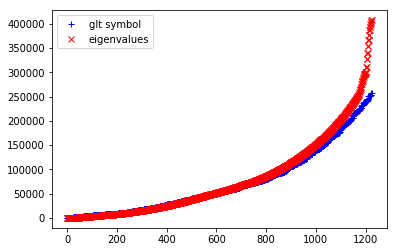

In [12]:
plt.plot(t, "+b", label="glt symbol")
plt.plot(wr, "xr", label="eigenvalues")
plt.legend(loc=2);

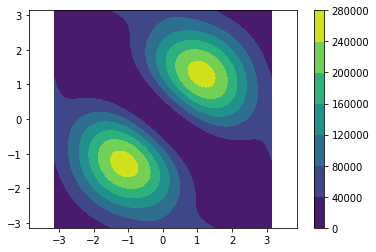

In [13]:
# ... compute the symbol f_a / f_c
nx = 100 ; ny = 100
t1 = linspace(-pi,pi, nx)
t2 = linspace(-pi,pi, ny)

x = linspace(0.,1.,nx)
y = linspace(0.,1.,ny)

f = zeros((nx, ny), order='F')
symbol_a(x,y,t1,t2, f, d_args['k_par'], d_args['b1'])
# ...

# ... plot
T1,T2 = meshgrid(t1,t2)
plt.contourf(T1, T2, f)
plt.axis("equal")
plt.colorbar();
# ...

Let's now create the symbol for linear B-Splines

In [14]:
# ...  create a finite element space
W1 = SplineSpace(degree=1, grid=grid_1)
W2 = SplineSpace(degree=1, grid=grid_2)

W = TensorSpace(W1, W2)
# ...

symbol_p1 = compile_symbol('symbol_p1', a, W,
                           d_constants=d_constants,
                           d_args=d_types,
                           backend='fortran')

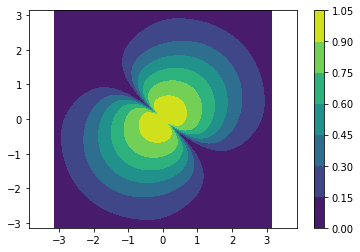

In [15]:
# ... compute the symbol f_a / f_c
nx = 100 ; ny = 100
t1 = linspace(-pi,pi, nx)
t2 = linspace(-pi,pi, ny)

x = linspace(0.,1.,nx)
y = linspace(0.,1.,ny)

f_a = zeros((nx, ny), order='F')
symbol_a(x,y,t1,t2, f_a, d_args['k_par'], d_args['b1'])

f_p1 = zeros((nx, ny), order='F')
symbol_p1(x,y,t1,t2, f_p1, d_args['k_par'], d_args['b1'])

f = f_a/f_p1
# ...

# ... plot
T1,T2 = meshgrid(t1,t2)
plt.contourf(T1, T2, f)
plt.axis("equal")
plt.colorbar();
# ...

## Variable coefficient case

In [2]:
# ... define the weak formulation
x,y = symbols('x y')

u = Symbol('u')
v = Symbol('v')

b0 = Function('b0')
b1 = Function('b1')

k_par = Constant('k_par')
k_perp = Constant('k_perp')

a = Lambda((x,y,v,u),
            k_par * (b0(x,y)*dx(v) + b1(x,y)*dy(v)) 
                  * (b0(x,y)*dx(u) + b1(x,y)*dy(u)) 
          + k_perp * Dot(Grad(v), Grad(u)))
# ...

# ... user defined function
def b0(x,y):
    from numpy import sqrt
    
    r = sqrt(x**2+y**2)
    b = -y/r
    
    return b

def b1(x,y):
    from numpy import sqrt

    r = sqrt(x**2+y**2)
    b = x/r
    
    return b
# ...

# ... create an interactive pyccel context
from pyccel.epyccel import ContextPyccel

context = ContextPyccel(name='context_2')
context.insert_function(b0, ['double', 'double'], 
                        kind='function', results=['double'])
context.insert_function(b1, ['double', 'double'], 
                        kind='function', results=['double'])

context.compile()
# ...

# ...  create a finite element space
p1  = 3 ; p2  = 3
ne1 = 32 ; ne2 = 32

grid_1 = linspace(0., 1., ne1+1)
grid_2 = linspace(0., 1., ne2+1)

V1 = SplineSpace(p1, grid=grid_1)
V2 = SplineSpace(p2, grid=grid_2)

V = TensorSpace(V1, V2)
# ...

# ...
d_constants = {'k_perp': 1.}
d_types = {'k_par': 'double'}

kernel_f90 = compile_kernel('kernel_2', a, V,
                            context=context,
                            d_constants=d_constants,
                            d_args=d_types,
                            backend='fortran')
# ...

pyccel: [semantic] 
 |warning| Duplicated import  (sqrt)

pyccel: [codegen] 
 |warning| Duplicated import  (sqrt)

pyccel: [semantic] 
 |warning| Duplicated import  (sqrt)

pyccel: [semantic] 
 |warning| Duplicated import  (sqrt)

pyccel: [codegen] 
 |warning| Duplicated import  (sqrt)



In [3]:
d_args = {'k_par': 1.e5}
M = assemble_matrix(V, kernel_f90, args=d_args).tocsr()

In [4]:
# import eigenvalue solver
from scipy.linalg import eig

M = M.todense()
w, v = eig(M)
wr = w.real
wr.sort()

In [5]:
symbol_a = compile_symbol('symbol_2', a, V,
                          context=context,
                          d_constants=d_constants,
                          d_args=d_types,
                          backend='fortran')

pyccel: [semantic] 
 |warning| Duplicated import  (sqrt)

pyccel: [semantic] 
 |warning| Duplicated import  (sqrt)

pyccel: [codegen] 
 |warning| Duplicated import  (sqrt)



In [6]:
# ... example of symbol evaluation
[n1,n2] = [W.nbasis for W in V.spaces]

t1 = linspace(-pi,pi, n1)
t2 = linspace(-pi,pi, n2)
x1 = linspace(0.,1., n1)
x2 = linspace(0.,1., n2)
e = zeros((n1, n2), order='F')
symbol_a(x1,x2,t1,t2, e, d_args['k_par'])
t = e.ravel()
t.sort()
# ...

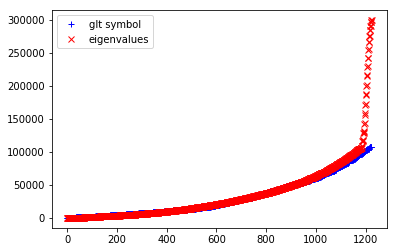

In [7]:
plt.plot(t, "+b", label="glt symbol")
plt.plot(wr, "xr", label="eigenvalues")
plt.legend(loc=2);

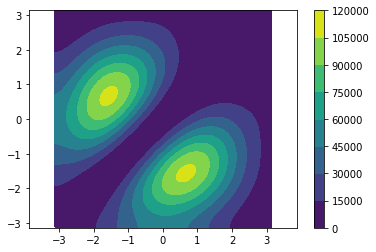

In [8]:
# ... compute the symbol f_a / f_c
nx = 100 ; ny = 100
t1 = linspace(-pi,pi, nx)
t2 = linspace(-pi,pi, ny)

x = linspace(0.,1.,nx)
y = linspace(0.,1.,ny)

f = zeros((nx, ny), order='F')
symbol_a(x,y,t1,t2, f, d_args['k_par'])
# ...

# ... plot
T1,T2 = meshgrid(t1,t2)
plt.contourf(T1, T2, f)
plt.axis("equal")
plt.colorbar();
# ...

In [9]:
# ...  create a finite element space
W1 = SplineSpace(degree=1, grid=grid_1)
W2 = SplineSpace(degree=1, grid=grid_2)

W = TensorSpace(W1, W2)
# ...

symbol_p1 = compile_symbol('symbol_p1_2', a, W,
                           context=context,
                           d_constants=d_constants,
                           d_args=d_types,
                           backend='fortran')

pyccel: [semantic] 
 |warning| Duplicated import  (sqrt)

pyccel: [semantic] 
 |warning| Duplicated import  (sqrt)

pyccel: [codegen] 
 |warning| Duplicated import  (sqrt)



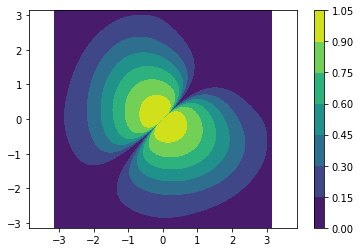

In [10]:
# ... compute the symbol f_a / f_c
nx = 200 ; ny = 200
t1 = linspace(-pi,pi, nx)
t2 = linspace(-pi,pi, ny)

x = linspace(0.,1.,nx)
y = linspace(0.,1.,ny)

f_a = zeros((nx, ny), order='F')
symbol_a(x,y,t1,t2, f_a, d_args['k_par'])

f_p1 = zeros((nx, ny), order='F')
symbol_p1(x,y,t1,t2, f_p1, d_args['k_par'])

f = f_a/f_p1
# ...

# ... plot
T1,T2 = meshgrid(t1,t2)
plt.contourf(T1, T2, f)
plt.axis("equal")
plt.colorbar();
# ...

In [15]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()